## 8- SMOTE modeling experiment 3 - Autogluon TabularPredictor (AutoML)
* Using the open-source Autogluon AutoML library by AWS.
* Using baseline dataset but with applying __SMOTE__ on train set.
* Autogluon will train an ensemble of models and find the best performing one.
    * Model will be __fit__ on the __train__ set.
    * The __validation__ set will be used to pick the best-performing model.
    * Final evaluation will be done on the __test__ set.

#### Stages
1. __Reading data__.
2. __Preparing data and Applying SMOTE to train set__.
3. __Autogluon model training__.
4. __Model evaluation__.
5. __Saving predictor__.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold  # for splitting into train/val/test based on customer id while keeping fraud ratio the same for the three sets
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    average_precision_score, 
    confusion_matrix, 
    classification_report
)
import autogluon
from autogluon.tabular import TabularPredictor
import warnings
warnings.filterwarnings("ignore")
import os
from imblearn.over_sampling import SMOTE 

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 420
np.random.seed(RANDOM_SEED)

### 1- Reading data

In [3]:
train_df = pd.read_csv("data/train_baseline.csv")
val_df = pd.read_csv("data/validation_baseline.csv")
test_df = pd.read_csv("data/test_baseline.csv")

In [4]:
train_df.shape

(476608, 30)

In [5]:
train_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.303248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,0.018468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.098661,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.186943,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,-0.017797,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [6]:
val_df.shape

(60291, 30)

In [7]:
val_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.020728,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.168078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.071645,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.234106,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.622063,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
test_df.shape

(57744, 30)

In [9]:
test_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.048201,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.068440,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.184287,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,0.027718,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.457954,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


### 2- Applying SMOTE to train set

In [10]:
target_column = "fraud"

In [11]:
feature_columns = [column for column in train_df.columns if column != target_column]

In [12]:
X_train = train_df[feature_columns].copy()
y_train = train_df[target_column].astype(int).copy()

In [13]:
smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=10)

In [14]:
X_train.shape

(476608, 29)

In [15]:
y_train.shape

(476608,)

In [16]:
y_train.value_counts().to_frame()

,count
fraud,
0,470978
1,5630


In [17]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [18]:
train_df = X_train.copy(deep=True)

In [19]:
train_df["fraud"] = y_train

In [20]:
train_df.shape

(941956, 30)

In [21]:
train_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.303248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,0.018468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.098661,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.186943,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,-0.017797,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [22]:
train_df["fraud"].value_counts().to_frame()

,count
fraud,
0,470978
1,470978


### 3- Autogluon model training

In [23]:
save_path = 'models/smote-autogluon-tabular-predictor' 

In [24]:
%%time

predictor = TabularPredictor(
    label="fraud",
    problem_type="binary",
    eval_metric="f1",
    path=save_path,
    sample_weight="balance_weight"
).fit(
    train_data=train_df,
    tuning_data=val_df,
    presets="medium_quality",
    verbosity=False,
    use_bag_holdout=True,
    num_cpus=os.cpu_count(),
    # Reproducbile results
    ag_args_fit={"random_seed": RANDOM_SEED}, # seed that every model will use
    ag_args_ensemble={
        "model_random_seed": RANDOM_SEED, # seed for per-fold child models
        "random_state": RANDOM_SEED  # seed for CV split in bagging
    }  
)

CPU times: user 18h 34min, sys: 1min 54s, total: 18h 35min 54s
Wall time: 2h 8min 13s


### 4- Model evaluation

In [25]:
def evaluate_model(model, X, y, name="model"):
    # # predictions
    # if hasattr(model, "predict_proba"):
    #     scores = model.predict_proba(X)[:, 1]
    # elif hasattr(model, "decision_function"):
    #     scores = model.decision_function(X)
    # else:
        # scores = model.predict(X)
    scores = model.predict(X)
        
    preds = (scores >= 0.5).astype(int)

    # metrics
    metrics = {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, zero_division=0),
        "recall": recall_score(y, preds, zero_division=0),
        "f1": f1_score(y, preds, zero_division=0),
        "roc_auc": roc_auc_score(y, scores) if len(np.unique(y)) > 1 else np.nan,
        "avg_precision": average_precision_score(y, scores),
        "classification_report": classification_report(y, preds, digits=3)
    }
    print(f"\n{name} — metrics\n")
    for k in ["accuracy", "precision", "recall", "f1", "roc_auc", "avg_precision"]:
        v = metrics[k]
        print(f"{k:>14}: {v:.4f}" if v==v else f"{k:>14}: nan")
    print("\nClassification report:\n", metrics["classification_report"])
    
    # confusion matrix
    cm = confusion_matrix(y, preds, labels=[0, 1])
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        fmt="d",
        cbar=True,
        annot=True,
        xticklabels=("Non_Fraudulent", "Fraudulent"),
        yticklabels=("Non_Fraudulent", "Fraudulent"),
        ax=ax,
        cmap="cividis"
    )
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()
    return metrics

#### 4.1- Evaluation on validation set

In [26]:
%%time

predictor.evaluate(val_df)

CPU times: user 1min 27s, sys: 612 ms, total: 1min 28s
Wall time: 6.38 s


{'f1': 0.6682242990654206,
 'accuracy': 0.9952895125308918,
 'balanced_accuracy': np.float64(0.7831781992740896),
 'mcc': 0.6768343357515977,
 'roc_auc': np.float64(0.9896878959990506),
 'precision': 0.8125,
 'recall': 0.5674603174603174}

In [27]:
leaderboard_val = predictor.leaderboard(val_df).sort_values("score_val", ascending=False)

In [28]:
leaderboard_val.shape

(12, 13)

In [29]:
leaderboard_val.head(50)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
5,WeightedEnsemble_L2,0.668224,0.356048,f1,6.136889,5.627622,244.985459,0.011689,0.005553,1.103486,2,True,12
6,LightGBMLarge,0.664640,0.354825,f1,5.634794,5.490823,187.297567,5.634794,5.490823,187.297567,1,True,11
3,LightGBM,0.691954,0.347386,f1,2.887427,3.294725,155.704497,2.887427,3.294725,155.704497,1,True,2
7,RandomForestGini,0.652284,0.332574,f1,0.490406,0.131246,56.584406,0.490406,0.131246,56.584406,1,True,3
8,RandomForestEntr,0.652005,0.330402,f1,0.425757,0.111899,55.508679,0.425757,0.111899,55.508679,1,True,4
2,XGBoost,0.708798,0.312042,f1,0.786845,0.787064,51.769258,0.786845,0.787064,51.769258,1,True,9
10,ExtraTreesGini,0.535456,0.299192,f1,0.275189,0.154006,53.404239,0.275189,0.154006,53.404239,1,True,6
9,ExtraTreesEntr,0.592490,0.295345,f1,0.414221,0.118823,58.520285,0.414221,0.118823,58.520285,1,True,7
0,LightGBMXT,0.712778,0.292059,f1,3.868287,4.761924,225.093119,3.868287,4.761924,225.093119,1,True,1
1,NeuralNetTorch,0.711004,0.282286,f1,0.121627,0.117148,6563.468204,0.121627,0.117148,6563.468204,1,True,10



SMOTE Experiment - Autogluon Validation Set — metrics

      accuracy: 0.9953
     precision: 0.8125
        recall: 0.5675
            f1: 0.6682
       roc_auc: 0.7832
 avg_precision: 0.4647

Classification report:
               precision    recall  f1-score   support

           0      0.996     0.999     0.998     59787
           1      0.812     0.567     0.668       504

    accuracy                          0.995     60291
   macro avg      0.904     0.783     0.833     60291
weighted avg      0.995     0.995     0.995     60291



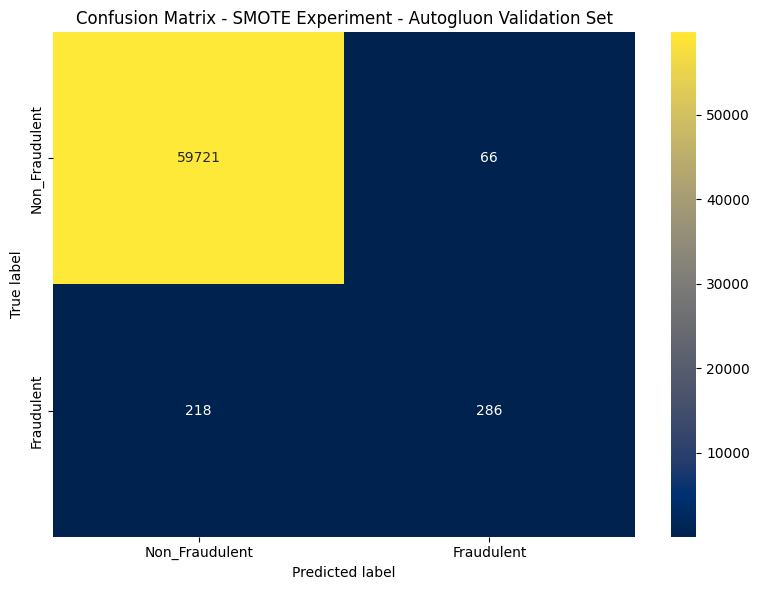

CPU times: user 1min 28s, sys: 288 ms, total: 1min 28s
Wall time: 6.2 s


In [30]:
%%time

target_column = "fraud"
feature_columns = [column for column in train_df.columns if column != target_column]

X_val = val_df[feature_columns].copy()
y_val = val_df[target_column].astype(int).copy()

metrics = evaluate_model(
    model=predictor,
    X=X_val,
    y=y_val,
    name="SMOTE Experiment - Autogluon Validation Set"
)

#### 4.2- Evaluation on test set

In [31]:
%%time

predictor.evaluate(test_df)

CPU times: user 1min 23s, sys: 220 ms, total: 1min 24s
Wall time: 5.83 s


{'f1': 0.697594501718213,
 'accuracy': 0.9908561928512053,
 'balanced_accuracy': np.float64(0.7850209342305472),
 'mcc': 0.7113069528594855,
 'roc_auc': np.float64(0.9899352267279686),
 'precision': 0.8955882352941177,
 'recall': 0.5712945590994372}

In [32]:
leaderboard_test = predictor.leaderboard(test_df).sort_values("score_test", ascending=False)

In [33]:
leaderboard_test.shape

(12, 13)

In [34]:
leaderboard_test.head(50)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.736490,0.347386,f1,2.780329,3.294725,155.704497,2.780329,3.294725,155.704497,1,True,2
1,LightGBMXT,0.728105,0.292059,f1,3.789926,4.761924,225.093119,3.789926,4.761924,225.093119,1,True,1
2,LightGBMLarge,0.727085,0.354825,f1,5.454074,5.490823,187.297567,5.454074,5.490823,187.297567,1,True,11
3,NeuralNetTorch,0.725160,0.282286,f1,0.127283,0.117148,6563.468204,0.127283,0.117148,6563.468204,1,True,10
4,XGBoost,0.717225,0.312042,f1,0.750601,0.787064,51.769258,0.750601,0.787064,51.769258,1,True,9
5,WeightedEnsemble_L2,0.697595,0.356048,f1,5.739777,5.627622,244.985459,0.011845,0.005553,1.103486,2,True,12
6,NeuralNetFastAI,0.696279,0.276514,f1,0.300935,0.206044,252.947890,0.300935,0.206044,252.947890,1,True,8
7,RandomForestGini,0.656934,0.332574,f1,0.273858,0.131246,56.584406,0.273858,0.131246,56.584406,1,True,3
8,RandomForestEntr,0.647678,0.330402,f1,0.426897,0.111899,55.508679,0.426897,0.111899,55.508679,1,True,4
9,ExtraTreesEntr,0.564343,0.295345,f1,0.431362,0.118823,58.520285,0.431362,0.118823,58.520285,1,True,7



SMOTE Experiment - Autogluon Test Set — metrics

      accuracy: 0.9909
     precision: 0.8956
        recall: 0.5713
            f1: 0.6976
       roc_auc: 0.7850
 avg_precision: 0.5196

Classification report:
               precision    recall  f1-score   support

           0      0.992     0.999     0.995     56678
           1      0.896     0.571     0.698      1066

    accuracy                          0.991     57744
   macro avg      0.944     0.785     0.846     57744
weighted avg      0.990     0.991     0.990     57744



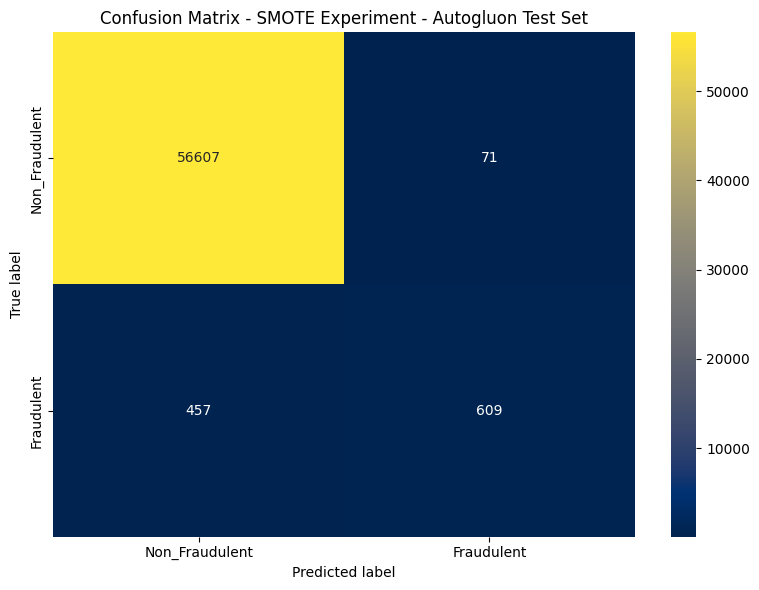

CPU times: user 1min 24s, sys: 208 ms, total: 1min 24s
Wall time: 5.95 s


In [35]:
%%time

target_column = "fraud"
feature_columns = [column for column in train_df.columns if column != target_column]

X_test = test_df[feature_columns].copy()
y_test = test_df[target_column].astype(int).copy()

metrics = evaluate_model(
    model=predictor,
    X=X_test,
    y=y_test,
    name="SMOTE Experiment - Autogluon Test Set"
)

### 5- Saving predictor

In [36]:
%%time

predictor.save()

CPU times: user 155 ms, sys: 4 ms, total: 159 ms
Wall time: 158 ms
